Installing **cleverhans** library for performing attack

In [1]:
!git clone "https://github.com/Georgsiedel/Lp-norm-corruption-robustness.git"

Cloning into 'Lp-norm-corruption-robustness'...
remote: Enumerating objects: 716, done.
remote: Total 716 (delta 0), reused 0 (delta 0), pack-reused 716
Receiving objects: 100% (716/716), 1.22 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (367/367), done.


In [2]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.7 MB/s eta 0:00:00


Importing necessary libraries used in the Notebook

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
import matplotlib.pyplot as plt
import numpy as np

Initiating **cuda** GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading **test images** using DataLoader with **batch_size = 1** because we want to calculate distance for each test image

In [5]:
BATCH_SIZE = 1

transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root="~/data",
                           train=False,
                           transform=transform,
                           download=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)


100%|██████████| 170498071/170498071 [00:01<00:00, 85537105.79it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data


Loading the trained model (ResNet 50)

In [6]:
import sys
sys.path.append("/content/Lp-norm-corruption-robustness/experiments")

In [7]:
import network
net = network.WideResNet(28, 10, 0.3, 10)
net=  torch.nn.DataParallel(net)
PATH = "/content/wrn28-no-resize-standard.pth"
state_dict = torch.load(PATH)
net.load_state_dict(state_dict["net"], strict=True)

<All keys matched successfully>

In [8]:
net.eval()

DataParallel(
  (module): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): Sequential(
      (0): WideBasic(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Sequential(
          (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): WideBasic(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, af

Projected gradient descent attack method with early stopping functionality

In [13]:
correct, total = 0, 0
for i, data in enumerate(testloader):
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  
  outputs = net(inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  accuracy = correct/total

print(f"Test Accuracy: {accuracy*100}%")

Test Accuracy: 94.69%


In [14]:
def pgd_with_early_stopping(model, inputs, labels, eps, number_of_iters, epsilon_iters, norm):

  label_flipped = False
  
  for i in range(number_of_iters):

    adv_inputs = projected_gradient_descent(model,
                                            inputs,
                                            eps=eps,
                                            eps_iter=epsilon_iters,
                                            nb_iter=1,
                                            norm=norm,
                                            rand_init=False,
                                            sanity_checks=False)
    

    outputs = model(adv_inputs)

    _, predicted = torch.max(outputs.data, 1)

    label_flipped = bool(predicted!=labels)

    if label_flipped:
      print(f"Iterations for successful attack: {i+1}")
      break
    inputs = adv_inputs.clone()
  return adv_inputs

Clearing of CUDA Memory for efficient computation

In [15]:
torch.cuda.empty_cache()

Defining required parameters for attack

In [16]:
epsilon = 0.1
eps_iter = 0.0004
nb = 50
norm = np.inf

Calculating adversarial distance including misclassified inputs

In [17]:
def adv_distance_calculation(testloader, model):  
  distance_list_0, image_idx_0 = [], []  
  distance_list_1, image_idx_1 = [], []  
  distance_list_2, image_idx_2 = [], []

  for i, data in enumerate(testloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    adv_inputs = pgd_with_early_stopping(model, inputs, labels, epsilon, nb, eps_iter, norm)

    distance = torch.norm((inputs-adv_inputs), p=1)
    distance_list_0.append(distance)
    image_idx_0.append(i)

    if (predicted==labels):

      distance = torch.norm((inputs-adv_inputs), p=1)
      distance_list_1.append(distance)
      distance_list_2.append(distance)
      image_idx_1.append(i)
      image_idx_2.append(i)

    else:
      distance_list_1.append(0)
      image_idx_1.append(i)

    if i%100 == 0:
      print(f"Completed: {i}, l1_distance: {distance}")
  return distance_list_0, image_idx_0, distance_list_1, image_idx_1, distance_list_2, image_idx_2

Conversion of input_metric to its numpy type for plotting

In [18]:
dst0, idx0, dst1, idx1, dst2, idx2 = adv_distance_calculation(testloader, net)

Streaming output truncated to the last 5000 lines.
Iterations for successful attack: 2
Iterations for successful attack: 50
Iterations for successful attack: 22
Iterations for successful attack: 12
Iterations for successful attack: 37
Iterations for successful attack: 10
Iterations for successful attack: 17
Iterations for successful attack: 34
Iterations for successful attack: 32
Iterations for successful attack: 13
Iterations for successful attack: 9
Iterations for successful attack: 20
Iterations for successful attack: 38
Iterations for successful attack: 9
Iterations for successful attack: 32
Completed: 4900, l1_distance: 27.911632537841797
Iterations for successful attack: 16
Iterations for successful attack: 4
Iterations for successful attack: 5
Iterations for successful attack: 29
Iterations for successful attack: 20
Iterations for successful attack: 9
Iterations for successful attack: 9
Iterations for successful attack: 7
Iterations for successful attack: 37
Iterations for succe

In [19]:
def conv(input_metric):
  input_metric_tensor = torch.tensor(input_metric)
  input_metric_np = input_metric_tensor.cpu().numpy()
  return input_metric_np

Visualization

In [20]:
import csv

In [25]:

import plotly.graph_objs as go
import plotly.offline as pyo

distance_list_0_np = conv(dst0)
distance_list_1_np = conv(dst1)
distance_list_2_np = conv(dst2)

with open("/content/data", "w", newline="") as csv_file:
  writer = csv.writer(csv_file)
  writer.writerows([distance_list_0_np, distance_list_1_np, distance_list_2_np])


# Create trace objects for each line plot
marker_size = 3

trace_0 = go.Scatter(x=idx0, y=distance_list_0_np, mode='markers', name='L1 distances (including misclassified inputs)', marker=dict(color='red', size = marker_size))
trace_1 = go.Scatter(x=idx1, y=distance_list_1_np, mode='markers', name='L1 distances (distance=0 for misclassified inputs)', marker=dict(color='green', size = marker_size))
trace_2 = go.Scatter(x=idx2, y=distance_list_2_np, mode='markers', name='L1 distances (excluding for misclassified inputs)', marker=dict(color='blue', size = marker_size))

# Create a data list containing the trace objects
data = [trace_0, trace_1, trace_2]

# Define the layout for the plot
layout = go.Layout(title='L1 Distances for all Inputs and Misclassified Inputs', xaxis=dict(title='Image index'), yaxis=dict(title='L1 distance'))

# Create a figure object
fig = go.Figure(data=data, layout=layout)

# Display the plot in the notebook
pyo.iplot(fig)


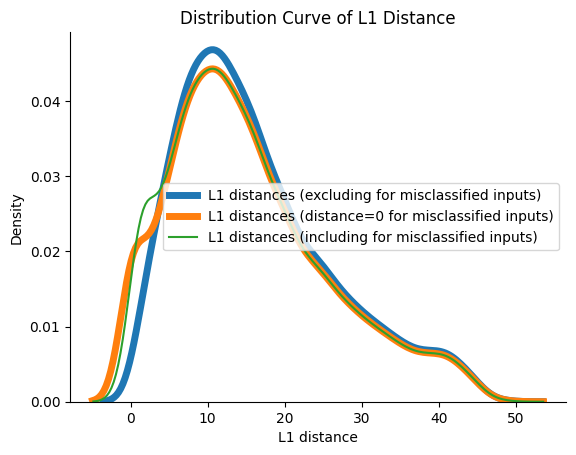

In [26]:
import seaborn as sns

linewidth = 5

sns.kdeplot(distance_list_2_np, label = 'L1 distances (excluding for misclassified inputs)', linewidth=linewidth)
sns.kdeplot(distance_list_1_np, label = "L1 distances (distance=0 for misclassified inputs)", linewidth=linewidth)
sns.kdeplot(distance_list_0_np, label = "L1 distances (including for misclassified inputs)")
sns.despine()
plt.xlabel("L1 distance")
plt.ylabel("Density")
plt.title("Distribution Curve of L1 Distance")
plt.legend()